In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [2]:
# Path dataset
main_path = 'dataset'

In [3]:
# Membaca data dari folder
data = []
for folder in os.listdir(main_path):
    folder_path = os.path.join(main_path, folder)
    if os.path.isdir(folder_path):
        print(f"Reading folder: {folder}")
        for file in os.listdir(folder_path):
            if file.endswith('.jpg') or file.endswith('.jpeg'):
                data.append((os.path.join(folder_path, file), folder))

Reading folder: baterai
Reading folder: biologis
Reading folder: gelas
Reading folder: kardus
Reading folder: kertas
Reading folder: metal
Reading folder: pakaian
Reading folder: plastik
Reading folder: sepatu


In [4]:
# DataFrame dari data
df = pd.DataFrame(data, columns=['images', 'label'])
print(df['label'].value_counts())

label
biologis    5819
pakaian     5325
gelas       4552
plastik     4291
kertas      3715
kardus      2977
metal       2805
sepatu      1977
baterai      945
Name: count, dtype: int64


In [5]:
# Split dataset menjadi train, validation, dan test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1, stratify=train_df['label'])
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(20739, 2)
(5185, 2)
(6482, 2)


In [6]:
# Definisikan parameter gambar
img_height, img_width = 224, 224
batch_size = 32

In [7]:
# Preprocessing Data dengan Augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30, 
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.3,
    zoom_range=0.3,  
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],  
    channel_shift_range=0.2,
    validation_split=0.2  # Menambahkan split untuk validation set
)
# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=1,  # Seed untuk reproduktibilitas
    subset='training'  # Menentukan subset untuk train
)
# Validation generator
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,  # Jangan shuffle validation data
    seed=1,  # Seed untuk reproduktibilitas
    subset='validation'  # Menentukan subset untuk validation
)

# Test generator
test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,  # Jangan shuffle test data
    seed=1  # Seed untuk reproduktibilitas
)

Found 16592 validated image filenames belonging to 9 classes.
Found 4147 validated image filenames belonging to 9 classes.
Found 6482 validated image filenames belonging to 9 classes.


In [10]:
# Mendapatkan jumlah kelas
num_classes = len(train_df['label'].unique())
# Membangun model
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.6)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('model_best.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
]

In [12]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=30,  # Anda dapat menyesuaikan jumlah epoch
    callbacks=callbacks
)

Epoch 1/30


c:\Users\adiaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


518/518 ━━━━━━━━━━━━━━━━━━━━ 409s 774ms/step - accuracy: 0.4813 - loss: 1.5379 - val_accuracy: 0.8031 - val_loss: 0.6211 - learning_rate: 0.0010
Epoch 2/30
  1/518 ━━━━━━━━━━━━━━━━━━━━ 3:14 376ms/step - accuracy: 0.7188 - loss: 0.9745

c:\Users\adiaz\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7188 - loss: 0.9745 - val_accuracy: 0.8421 - val_loss: 0.5073 - learning_rate: 0.0010
Epoch 3/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 392s 752ms/step - accuracy: 0.7276 - loss: 0.8264 - val_accuracy: 0.8336 - val_loss: 0.5331 - learning_rate: 0.0010
Epoch 4/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.7812 - loss: 0.6342 - val_accuracy: 0.9474 - val_loss: 0.3619 - learning_rate: 0.0010
Epoch 5/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 399s 766ms/step - accuracy: 0.7692 - loss: 0.7285 - val_accuracy: 0.8338 - val_loss: 0.5048 - learning_rate: 0.0010
Epoch 6/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.7812 - loss: 0.6916 - val_accuracy: 0.8421 - val_loss: 0.3818 - learning_rate: 0.0010
Epoch 7/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 378s 726ms/step - accuracy: 0.7887 - loss: 0.6963 - val_accuracy: 0.8418 - val_loss: 0.5030 - learning_rate: 0.0010
Epoch 8/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.8438 - loss: 0.

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

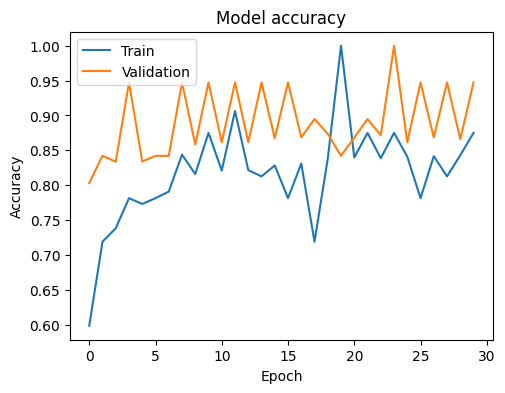

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

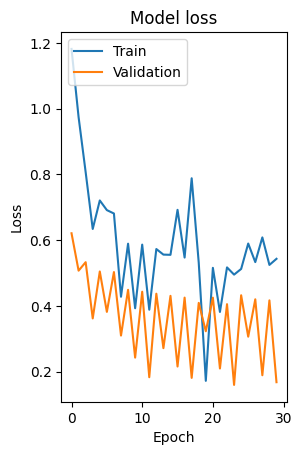

In [15]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 117s 577ms/step - accuracy: 0.8505 - loss: 0.4574
Test Loss: 0.43777409195899963
Test Accuracy: 0.8599197864532471


In [17]:
# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
class_labels = list(train_generator.class_indices.keys())

203/203 ━━━━━━━━━━━━━━━━━━━━ 128s 622ms/step


In [18]:
# Classification Report
print(classification_report(test_generator.classes, y_pred_classes, target_names=class_labels))

              precision    recall  f1-score   support

     baterai       0.87      0.80      0.83       189
    biologis       0.91      0.93      0.92      1164
       gelas       0.81      0.84      0.83       911
      kardus       0.84      0.80      0.82       596
      kertas       0.79      0.88      0.83       743
       metal       0.81      0.84      0.82       561
     pakaian       0.96      0.96      0.96      1065
     plastik       0.83      0.73      0.78       858
      sepatu       0.89      0.88      0.89       395

    accuracy                           0.86      6482
   macro avg       0.86      0.85      0.85      6482
weighted avg       0.86      0.86      0.86      6482



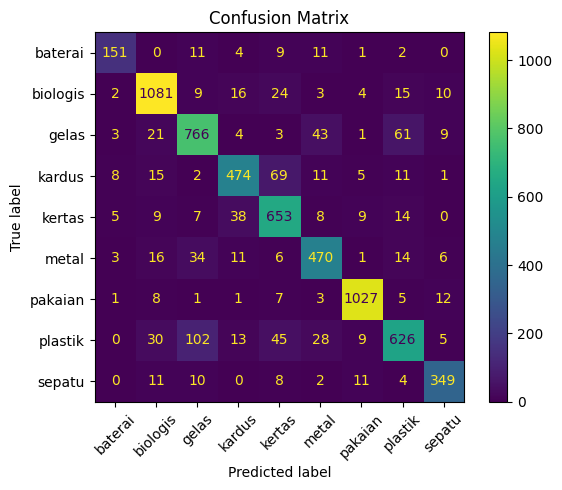

In [19]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred_classes)
confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
confusion_matrix_display.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Save the model
model.save("TrashClassifierFINAL.keras")
model.save("TrashClassifierFINAL.h5")


In [29]:
# Define category and handling instructions for each label
import cv2

# Define the class index mapping based on your training setup
train_class = {
    'baterai': 0,
    'biologis': 1,
    'gelas': 2,
    'kardus': 3,
    'kertas': 4,
    'metal': 5,
    'pakaian': 6,
    'plastik': 7,
    'sepatu': 8
}

category_mapping = {
    'baterai': 'anorganic',
    'biologis': 'organic',
    'gelas': 'anorganic',
    'kardus': 'anorganic',
    'kertas': 'anorganic',
    'metal': 'anorganic',
    'pakaian': 'anorganic',
    'plastik': 'anorganic',
    'sepatu': 'anorganic'
}

handling_instructions = {
    'baterai': """Baterai adalah sampah anorganik berbahaya yang mengandung bahan kimia beracun. Pengelolaannya harus dilakukan dengan hati-hati untuk menghindari kerusakan lingkungan.
- Kumpulkan baterai bekas di wadah terpisah.
- Jangan membuangnya bersama sampah rumah tangga.
- Bawa ke titik pengumpulan atau fasilitas daur ulang khusus untuk baterai.""",
    
    'biologis': """Sampah biologis atau organik adalah sisa-sisa bahan alami yang dapat terurai. Contohnya termasuk sisa makanan, daun, dan bahan taman.
- Kumpulkan sampah organik di tempat sampah khusus organik.
- Sampah organik bisa dikomposkan untuk menghasilkan pupuk alami.
- Hindari mencampur sampah organik dengan sampah anorganik untuk memudahkan proses pengomposan.""",
    
    'gelas': """Gelas adalah sampah anorganik yang dapat didaur ulang menjadi produk baru.
- Bersihkan gelas dari sisa makanan atau minuman.
- Pisahkan gelas berdasarkan warnanya jika memungkinkan.
- Bawa ke fasilitas daur ulang gelas atau letakkan di tempat sampah daur ulang gelas.""",
    
    'kardus': """Kardus adalah sampah anorganik yang terbuat dari serat kayu dan mudah didaur ulang.
- Lipat kardus agar tidak memakan banyak tempat.
- Pastikan kardus dalam keadaan bersih dan kering.
- Bawa ke fasilitas daur ulang kertas atau letakkan di tempat sampah daur ulang kertas.""",
    
    'kertas': """Kertas adalah sampah anorganik yang dapat didaur ulang menjadi produk kertas baru.
- Lipat atau gunting kertas agar lebih mudah diolah.
- Pastikan kertas dalam keadaan bersih dan kering.
- Bawa ke fasilitas daur ulang kertas atau letakkan di tempat sampah daur ulang kertas.""",
    
    'metal': """Metal adalah sampah anorganik yang dapat didaur ulang menjadi produk metal baru.
- Bersihkan metal dari sisa makanan atau bahan lainnya.
- Pisahkan metal berdasarkan jenisnya jika memungkinkan.
- Bawa ke fasilitas daur ulang metal atau letakkan di tempat sampah daur ulang metal.""",
    
    'pakaian': """Pakaian adalah sampah anorganik yang dapat didaur ulang atau digunakan kembali.
- Jika pakaian masih layak pakai, donasikan ke panti asuhan atau lembaga sosial.
- Jika tidak layak pakai, bawa ke fasilitas daur ulang tekstil.
- Pisahkan pakaian berdasarkan jenis kain jika memungkinkan.""",
    
    'plastik': """Plastik adalah sampah anorganik yang sangat sulit terurai tetapi dapat didaur ulang menjadi produk baru.
- Bersihkan plastik dari sisa makanan atau bahan lainnya.
- Pisahkan plastik berdasarkan jenisnya jika memungkinkan.
- Bawa ke fasilitas daur ulang plastik atau letakkan di tempat sampah daur ulang plastik.""",
    
    'sepatu': """Sepatu adalah sampah anorganik yang dapat didaur ulang atau digunakan kembali.
- Jika sepatu masih layak pakai, donasikan ke panti asuhan atau lembaga sosial.
- Jika tidak layak pakai, bawa ke fasilitas daur ulang tekstil.
- Pisahkan sepatu berdasarkan bahan pembuatannya jika memungkinkan.""",
}

# Function to predict and display the result
def predict_and_display(image_path):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (img_height, img_width))
    img_rescaled = img_resized / 255.0
    img_reshaped = np.expand_dims(img_rescaled, axis=0)

    prediction = model.predict(img_reshaped)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = list(train_class.keys())[list(train_class.values()).index(predicted_class_index)]
    predicted_category = category_mapping[predicted_class_label]
    predicted_handling = handling_instructions[predicted_class_label]

    print(f"Predicted Class: {predicted_class_label}")
    print(f"Category: {predicted_category}")
    print(f"Handling Instructions: {predicted_handling}")

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {predicted_class_label}\nCategory: {predicted_category}\nHandling: {predicted_handling}")
    plt.axis('off')
    plt.show()

In [3]:
import tensorflow as tf

# Memeriksa versi TensorFlow
print("Versi TensorFlow yang terpasang:", tf.__version__)

# Jika Anda menggunakan Keras dari TensorFlow (tf.keras), tidak perlu memeriksa versi Keras terpisah.
# Namun, jika Anda menggunakan Keras standalone, Anda dapat memeriksa versi Keras sebagai berikut:
try:
    import keras
    print("Versi Keras yang terpasang:", keras.__version__)
except ImportError:
    print("Keras tidak diimpor atau tidak digunakan standalone.")


Versi TensorFlow yang terpasang: 2.16.1
Versi Keras yang terpasang: 3.3.3


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: gelas
Category: anorganic
Handling Instructions: Gelas adalah sampah anorganik yang dapat didaur ulang menjadi produk baru.
- Bersihkan gelas dari sisa makanan atau minuman.
- Pisahkan gelas berdasarkan warnanya jika memungkinkan.
- Bawa ke fasilitas daur ulang gelas atau letakkan di tempat sampah daur ulang gelas.


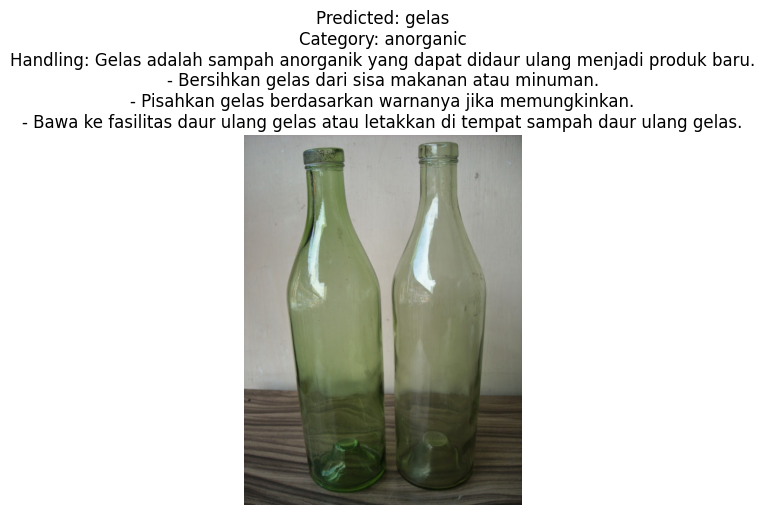

In [30]:
# Example usage
example_image_path = 'testModel/Botol kaca.JPG'
predict_and_display(example_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Class: plastik
Category: anorganic
Handling Instructions: Plastik adalah sampah anorganik yang sangat sulit terurai tetapi dapat didaur ulang menjadi produk baru.
- Bersihkan plastik dari sisa makanan atau bahan lainnya.
- Pisahkan plastik berdasarkan jenisnya jika memungkinkan.
- Bawa ke fasilitas daur ulang plastik atau letakkan di tempat sampah daur ulang plastik.


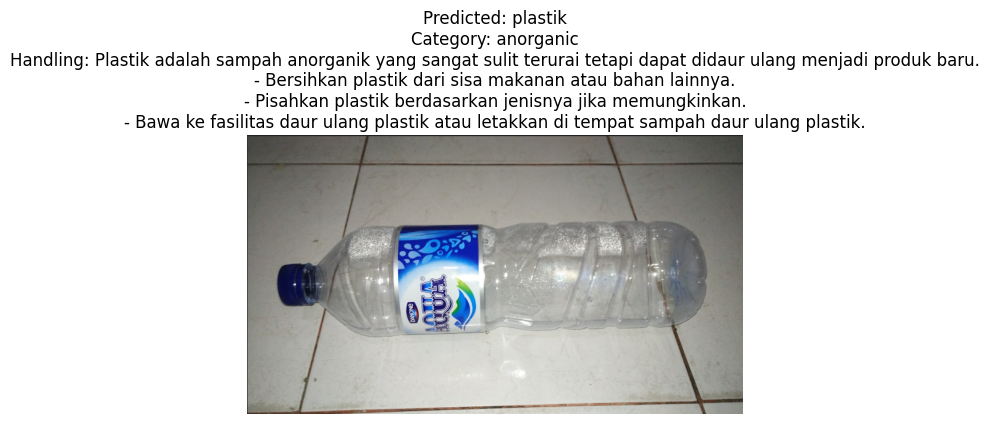

In [31]:
# Example usage
example_image_path = 'testModel/aqua.png'
predict_and_display(example_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Class: sepatu
Category: anorganic
Handling Instructions: Sepatu adalah sampah anorganik yang dapat didaur ulang atau digunakan kembali.
- Jika sepatu masih layak pakai, donasikan ke panti asuhan atau lembaga sosial.
- Jika tidak layak pakai, bawa ke fasilitas daur ulang tekstil.
- Pisahkan sepatu berdasarkan bahan pembuatannya jika memungkinkan.


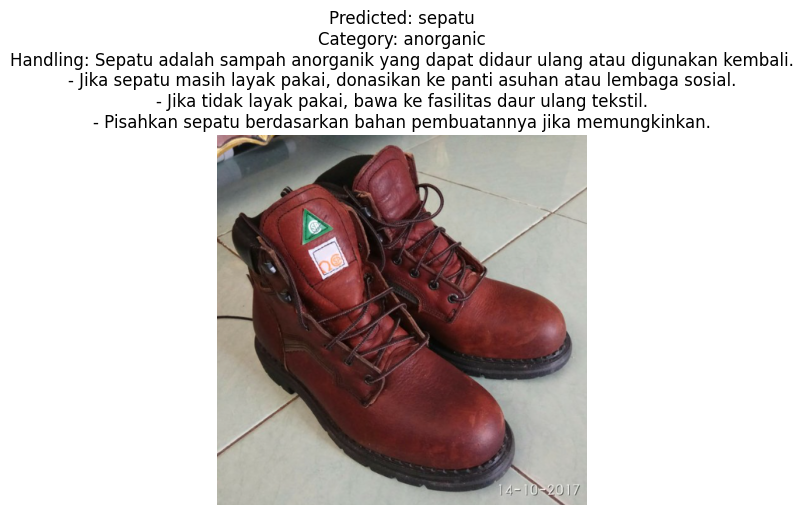

In [32]:
# Example usage
example_image_path = 'testModel/sapatu.png'
predict_and_display(example_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Class: pakaian
Category: anorganic
Handling Instructions: Pakaian adalah sampah anorganik yang dapat didaur ulang atau digunakan kembali.
- Jika pakaian masih layak pakai, donasikan ke panti asuhan atau lembaga sosial.
- Jika tidak layak pakai, bawa ke fasilitas daur ulang tekstil.
- Pisahkan pakaian berdasarkan jenis kain jika memungkinkan.


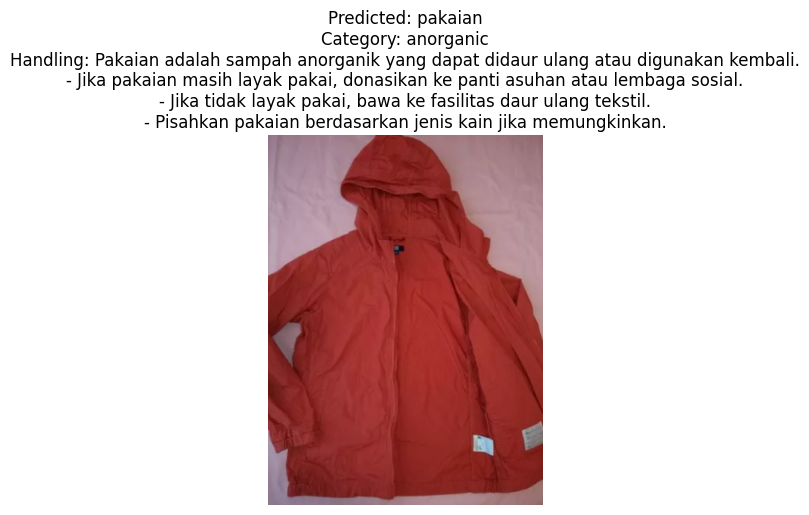

In [33]:
# Example usage
example_image_path = 'testModel/jeket.png'
predict_and_display(example_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Class: baterai
Category: anorganic
Handling Instructions: Baterai adalah sampah anorganik berbahaya yang mengandung bahan kimia beracun. Pengelolaannya harus dilakukan dengan hati-hati untuk menghindari kerusakan lingkungan.
- Kumpulkan baterai bekas di wadah terpisah.
- Jangan membuangnya bersama sampah rumah tangga.
- Bawa ke titik pengumpulan atau fasilitas daur ulang khusus untuk baterai.


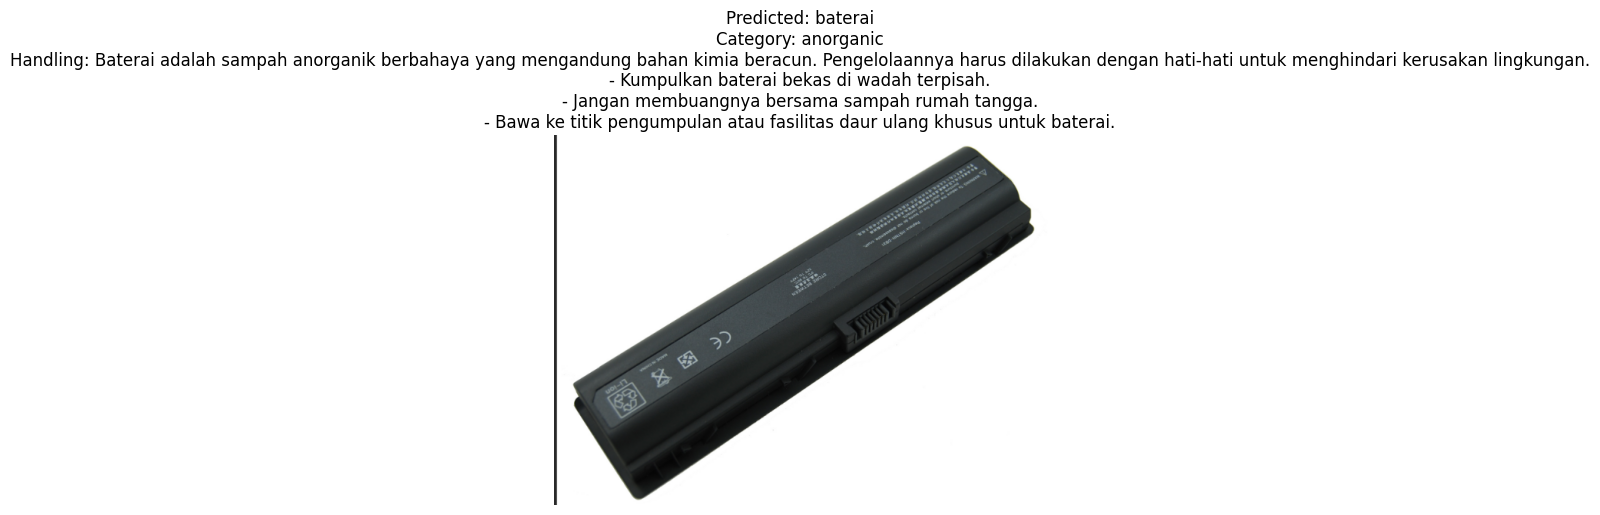

In [34]:
# Example usage
example_image_path = 'testModel/batre.png'
predict_and_display(example_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Class: metal
Category: anorganic
Handling Instructions: Metal adalah sampah anorganik yang dapat didaur ulang menjadi produk metal baru.
- Bersihkan metal dari sisa makanan atau bahan lainnya.
- Pisahkan metal berdasarkan jenisnya jika memungkinkan.
- Bawa ke fasilitas daur ulang metal atau letakkan di tempat sampah daur ulang metal.


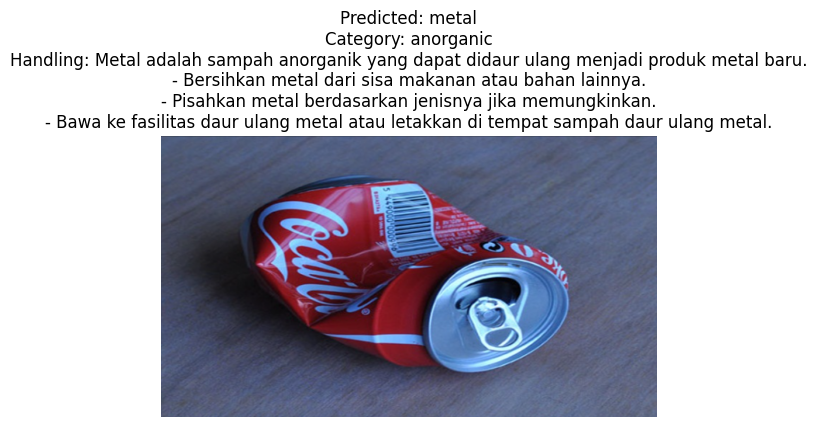

In [35]:
# Example usage
example_image_path = 'testModel/kokakola.png'
predict_and_display(example_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Class: kertas
Category: anorganic
Handling Instructions: Kertas adalah sampah anorganik yang dapat didaur ulang menjadi produk kertas baru.
- Lipat atau gunting kertas agar lebih mudah diolah.
- Pastikan kertas dalam keadaan bersih dan kering.
- Bawa ke fasilitas daur ulang kertas atau letakkan di tempat sampah daur ulang kertas.


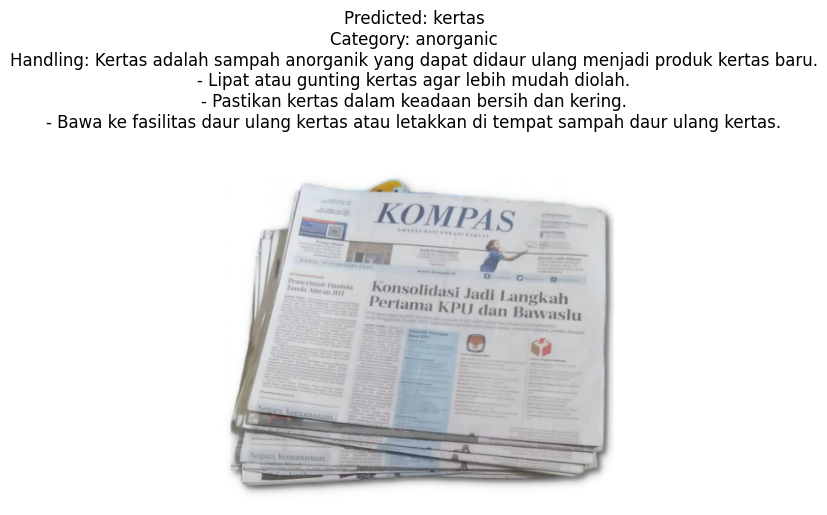

In [36]:
# Example usage
example_image_path = 'testModel/korang.png'
predict_and_display(example_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Class: kardus
Category: anorganic
Handling Instructions: Kardus adalah sampah anorganik yang terbuat dari serat kayu dan mudah didaur ulang.
- Lipat kardus agar tidak memakan banyak tempat.
- Pastikan kardus dalam keadaan bersih dan kering.
- Bawa ke fasilitas daur ulang kertas atau letakkan di tempat sampah daur ulang kertas.


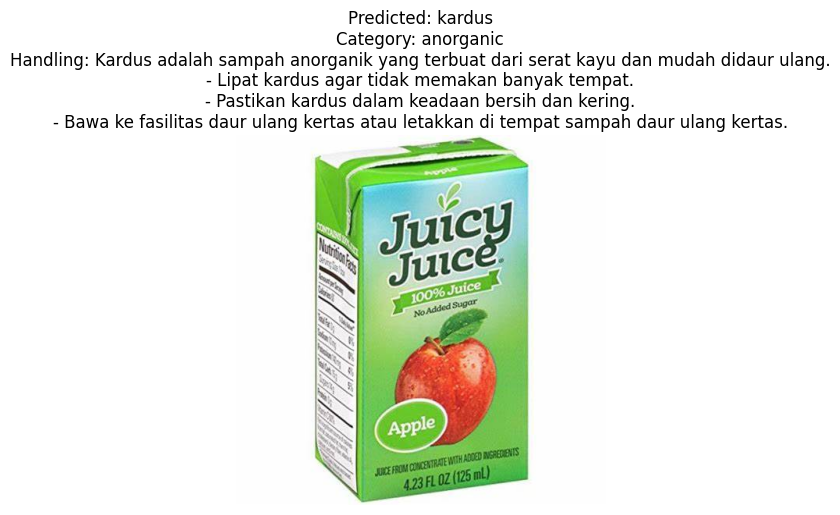

In [37]:
# Example usage
example_image_path = 'testModel/jus.jpg'
predict_and_display(example_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Class: biologis
Category: organic
Handling Instructions: Sampah biologis atau organik adalah sisa-sisa bahan alami yang dapat terurai. Contohnya termasuk sisa makanan, daun, dan bahan taman.
- Kumpulkan sampah organik di tempat sampah khusus organik.
- Sampah organik bisa dikomposkan untuk menghasilkan pupuk alami.
- Hindari mencampur sampah organik dengan sampah anorganik untuk memudahkan proses pengomposan.


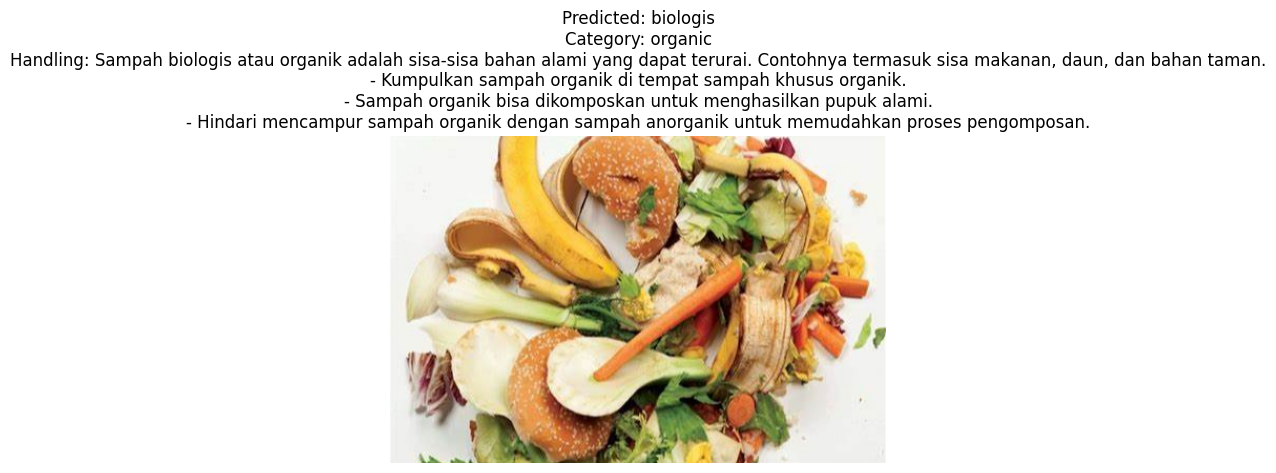

In [38]:
# Example usage
example_image_path = 'testModel/sisa.png'
predict_and_display(example_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Class: sepatu
Category: anorganic
Handling Instructions: Sepatu adalah sampah anorganik yang dapat didaur ulang atau digunakan kembali.
- Jika sepatu masih layak pakai, donasikan ke panti asuhan atau lembaga sosial.
- Jika tidak layak pakai, bawa ke fasilitas daur ulang tekstil.
- Pisahkan sepatu berdasarkan bahan pembuatannya jika memungkinkan.


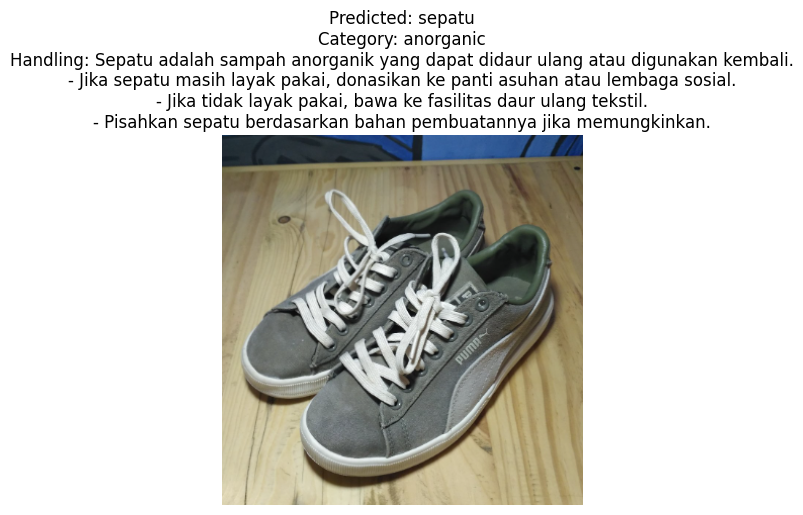

In [39]:
# Example usage
example_image_path = 'testModel/spatu.png'
predict_and_display(example_image_path)

In [1]:
import tensorflow as tf
from keras.models import load_model

# Muat model
model = load_model('../deploy model/model.h5')

# Periksa versi TensorFlow
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.16.1
